Import Libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Helper Functions

In [47]:
def get_coords(meta_angles, meta_length, phal_length, angles):
    # Initialize the Coords array (5 fingers, 4 points per finger, 3 coordinates)
    coords = np.zeros((5, 4, 3))
    
    # Compute the thumb's coordinate system
    thumb_coords = find_thumb_plane(meta_angles[0], angles[0, 2])
    first_point = np.array([0, meta_length[0], 0])  # Point on Y axis in local plane coordinates
    coords[0, 0, :] = np.dot(thumb_coords, first_point)  # Transform to global coordinates

    # Compute the second point for the thumb
    second_point = rotate_point_on_plane(coords[0, 0, :], phal_length[0, 0], angles[0, 0], thumb_coords)
    coords[0, 1, :] = second_point
    
    # Compute the third point for the thumb
    third_point = rotate_point_on_plane(coords[0, 1, :], phal_length[0, 1], np.sum(angles[0, 0:2]), thumb_coords)
    coords[0, 2, :] = third_point
    coords[0, 3, :] = np.nan  # Set the fourth point for the thumb to NaN

    # Loop through each finger (2 to 5)
    for i in range(1, 5):
        # Get the 3x3 plane for the current finger
        plane_coords = find_finger_plane(meta_angles[i])

        # First point: Located a distance meta_length[i] away from the origin on the plane
        first_point = np.array([0, meta_length[i], 0])  # Point on Y axis in local plane coordinates
        coords[i, 0, :] = np.dot(plane_coords, first_point)  # Transform to global coordinates

        # Update the plane coordinates for the next rotation
        plane_coords = find_finger_plane(meta_angles[i] + angles[i, 3])
        
        # Second point: Distance phal_length[i,0] from the first point, rotate by angles[i,0]
        second_point = rotate_point_on_plane(coords[i, 0, :], phal_length[i, 0], angles[i, 0], plane_coords)
        coords[i, 1, :] = second_point

        # Third point: Distance phal_length[i,1] from the second point, rotate by angles[i,1]
        third_point = rotate_point_on_plane(coords[i, 1, :], phal_length[i, 1], np.sum(angles[i, 0:2]), plane_coords)
        coords[i, 2, :] = third_point

        # Fourth point: Distance phal_length[i,2] from the third point, rotate by angles[i,2]
        fourth_point = rotate_point_on_plane(coords[i, 2, :], phal_length[i, 2], np.sum(angles[i, 0:3]), plane_coords)
        coords[i, 3, :] = fourth_point

    return coords

def rotate_point_on_plane(origin, distance, angle, plane_coords):
    # Convert angle to radians and add 90 degrees
    angle_rad = np.deg2rad(angle + 90)
    
    # Create a local point in the plane coordinates (move along X direction by distance)
    local_point = np.array([
        distance * np.cos(angle_rad),
        distance * np.sin(angle_rad),
        0  # Local Z-coordinate in the plane
    ])
    
    # Rotate the point to align with the plane and transform to global coordinates
    rotated_point = origin + np.dot(plane_coords, local_point)
    
    return rotated_point

def find_thumb_plane(A, B):
    # Convert angles A and B from degrees to radians
    A_rad = np.deg2rad(A)
    B_rad = np.deg2rad(B)

    # Define the rotation matrix around the X-axis
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, np.cos(A_rad), -np.sin(A_rad)],
        [0, np.sin(A_rad), np.cos(A_rad)]
    ])

    # Define the rotation matrix around the Y-axis
    rotation_matrix_y = np.array([
        [np.cos(B_rad), np.sin(B_rad), 0],
        [0, 0, 1],
        [-np.sin(B_rad), np.cos(B_rad), 0]
    ])

    rotation_matrix_xy = np.dot(rotation_matrix_y, rotation_matrix_x)

    return rotation_matrix_xy
def find_finger_plane(A):
    # Convert angle A from degrees to radians
    A_rad = np.deg2rad(A)
    
    # Define the rotation matrix around the X-axis
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, np.cos(A_rad), -np.sin(A_rad)],
        [0, np.sin(A_rad), np.cos(A_rad)]
    ])
    
    return rotation_matrix_x

def plot_hand_skeleton(Coords):
    E = np.array([0, 0, 0])
    coords_meta = Coords[:, 0, :]
    coords1 = Coords[0, :, :].reshape(4, 3)
    coords2 = Coords[1, :, :].reshape(4, 3)
    coords3 = Coords[2, :, :].reshape(4, 3)
    coords4 = Coords[3, :, :].reshape(4, 3)
    coords5 = Coords[4, :, :].reshape(4, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 2, 1])  # Aspect ratio for better visualization

    # Plot the skeleton lines
    for i in range(coords_meta.shape[0]):
        ax.plot([coords_meta[i, 0], E[0]], [coords_meta[i, 1], E[1]], [coords_meta[i, 2], E[2]], 'k-', linewidth=5)
        ax.plot(coords1[:, 0], coords1[:, 1], coords1[:, 2], 'b', linewidth=2)
        ax.plot(coords2[:, 0], coords2[:, 1], coords2[:, 2], 'r', linewidth=2)
        ax.plot(coords3[:, 0], coords3[:, 1], coords3[:, 2], 'g', linewidth=2)
        ax.plot(coords4[:, 0], coords4[:, 1], coords4[:, 2], 'c', linewidth=2)
        ax.plot(coords5[:, 0], coords5[:, 1], coords5[:, 2], 'm', linewidth=2)

        # Scatter points for each segment
        ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color='b', s=50)
        ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color='r', s=50)
        ax.scatter(coords3[:, 0], coords3[:, 1], coords3[:, 2], color='g', s=50)
        ax.scatter(coords4[:, 0], coords4[:, 1], coords4[:, 2], color='c', s=50)
        ax.scatter(coords5[:, 0], coords5[:, 1], coords5[:, 2], color='m', s=50)

    # Set labels and view parameters
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid(True)
    ax.view_init(elev=30, azim=30)  # Set the view angle
    ax.set_xlim([-100, 100])
    ax.set_ylim([0, 200])
    ax.set_zlim([-100, 100])

    plt.show()

Define Constants

In [48]:
meta_angles = [30, 12, 0, -15, -29]
meta_length = [48.22, 68.12, 64.6, 58, 53.69]
phal_length = np.array([
    [31.37, 21.87, np.nan],
    [39.78, 22.38, 15.82],
    [44.63, 26.23, 17.4],
    [41.37, 25.65, 17.3],
    [32.74, 18.11, 15.96]
])

Changeable Angles

In [49]:
i = 0
angles = np.array([
    [i, i, -45, 0],
    [i, i, i, 0],
    [i, i, i, 0],
    [i, i, i, 0],
    [i, i, i, 0]
])

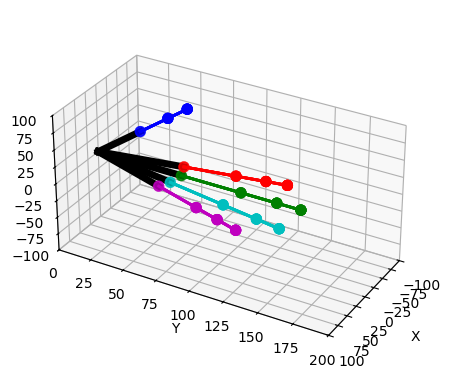

In [50]:
Coords = get_coords(meta_angles, meta_length, phal_length, angles)
plot_hand_skeleton(Coords)